In [1]:
# train a dominant detector
from pygod.detector import DOMINANT

from pygod.utils import load_data

data = load_data('weibo') # in PyG format
model = DOMINANT(num_layers=4, epoch=20)  # hyperparameters can be set here
model.fit(data)  # input data is a PyG data object

# get outlier scores on the training data (transductive setting)
score = model.decision_score_
print("training score: ", score)
# predict labels and scores on the testing data (inductive setting)
pred, score = model.predict(data, return_score=True)

print("predict score: ", score)

/home/shark/miniforge3/envs/gad_test_c/lib/python3.12/site-packages/pygod/utils/utility.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)
/h

training score:  tensor([1740.8672,  917.8134,  341.4017,  ..., 1194.1462,  622.9437,
        2881.2761])
predict score:  tensor([1489.1364,  813.9673,  298.5081,  ..., 1055.1726,  553.7695,
        2564.6584])


In [3]:
# Import necessary libraries
from pygod.detector import CONAD
from pygod.utils import load_data
from sklearn.metrics import roc_auc_score

# Load data in PyG format
data = load_data('weibo')

# Initialize and train the DOMINANT model
model = CONAD()  # Hyperparameters can be set here
model.fit(data)  # Input data is a PyG data object

# Get outlier scores on the training data (transductive setting)
train_score = model.decision_score_
print("Training score: ", train_score)

# Predict labels and scores on the testing data (inductive setting)
pred, test_score = model.predict(data, return_score=True)
print("Predict score: ", test_score)

# Extract ground truth labels from the data object
y_true = data.y.numpy()  # Ground truth labels (1 for anomalies, 0 for normal)

# Compute AUC using sklearn's roc_auc_score
auc_score = roc_auc_score(y_true, test_score)
print(f"AUC Score: {auc_score:.4f}")

/home/shark/miniforge3/envs/gad_test_c/lib/python3.12/site-packages/pygod/utils/utility.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)
/h

Training score:  tensor([168.8004,  77.7198,  59.4289,  ..., 100.1070, 103.9973, 351.9234])
Predict score:  tensor([167.3499,  77.0197,  59.2666,  ...,  99.1355, 103.0802, 347.6328])
AUC Score: 0.8801


In [6]:
import torch
x = torch.eye(4) + 2
x, x.sum(1).pow(-0.5)

(tensor([[3., 2., 2., 2.],
         [2., 3., 2., 2.],
         [2., 2., 3., 2.],
         [2., 2., 2., 3.]]),
 tensor([0.3333, 0.3333, 0.3333, 0.3333]))

In [5]:
from torch_geometric.utils import add_self_loops, add_remaining_self_loops
import torch

edge_index = torch.tensor([[0, 1, 2, 1], [1, 2, 0, 1]], dtype=torch.long)
edge_index, _ = add_remaining_self_loops(edge_index, num_nodes=3)

print(edge_index)
# 输出:
# tensor([[0, 1, 2, 0, 1, 2],
#         [1, 2, 0, 0, 1, 2]])

tensor([[0, 1, 2, 0, 1, 2],
        [1, 2, 0, 0, 1, 2]])


In [14]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm, x_i):
        # x_j has shape [E, out_channels]
        print("x_i: ", x_i.shape)
        print("x_j: ", x_j.shape)
        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [18]:
# 1. 创建一个随机图
# 假设我们有一个包含 4 个节点的图，每个节点有 16 维特征
num_nodes = 5
num_features = 8

# 节点特征矩阵 x: [num_nodes, num_features]
x = torch.rand((num_nodes, num_features))  # 随机生成节点特征

# 边索引 edge_index: [2, num_edges]
# 这里我们手动定义一些边 (0-1, 1-2, 2-3, 3-0)
edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 0]], dtype=torch.long)

# 2. 定义 GCNConv 层
in_channels = num_features  # 输入特征维度
out_channels = 16           # 输出特征维度
conv = GCNConv(in_channels, out_channels)

# 3. 前向传播
output = conv(x, edge_index)

# 打印结果
print("输入节点特征形状:", x.shape)
print("输出节点特征形状:", output.shape)
print("输出节点特征:")
print(output)

x_i:  torch.Size([9, 16])
x_j:  torch.Size([9, 16])
输入节点特征形状: torch.Size([5, 8])
输出节点特征形状: torch.Size([5, 16])
输出节点特征:
tensor([[ 0.3737,  0.5739,  0.3363, -0.0336, -0.0879, -0.2538,  0.3612,  0.2364,
         -0.3706,  0.3006,  0.0581, -0.3055, -0.0580,  0.3004, -0.5979, -0.2776],
        [ 0.2723,  0.6063,  0.2206, -0.1434, -0.1299, -0.3666,  0.2185,  0.0470,
         -0.3908,  0.2396,  0.2027, -0.2203, -0.2479,  0.3179, -0.5801, -0.2926],
        [ 0.2959,  0.6882,  0.4015, -0.2133, -0.1763, -0.3688,  0.1637,  0.1485,
         -0.4689,  0.3047,  0.1739, -0.3413, -0.1706,  0.2511, -0.7089, -0.2662],
        [ 0.3973,  0.6559,  0.5172, -0.1035, -0.1343, -0.2560,  0.3064,  0.3379,
         -0.4488,  0.3658,  0.0293, -0.4266,  0.0193,  0.2335, -0.7266, -0.2512],
        [ 0.3812,  0.4418,  0.4705,  0.1788, -0.0864, -0.1976,  0.3671, -0.1151,
         -0.0540,  0.3324,  0.2589, -0.3600, -0.2992,  0.3049, -0.7765, -0.2112]],
       grad_fn=<AddBackward0>)


In [20]:
from pygod.utils import load_data

data = load_data('inj_cora')
data.y = data.y.bool()
data

/home/shark/miniforge3/envs/gad_test_c/lib/python3.12/site-packages/pygod/utils/utility.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Data(x=[2708, 1433], edge_index=[2, 11060], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [23]:
x = torch.tensor([1, 2, 0, 3, 4, 0, 0])
x.nonzero()

tensor([[0],
        [1],
        [3],
        [4]])

In [3]:
def func():
    return 1, 2

func()

(1, 2)

In [4]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader

# 加载图数据集
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# 定义邻居采样参数
num_neigh = 5       # 每层采样的邻居数
num_layers = 2      # 模型的层数
batch_size = 32     # 批量大小

# 创建 NeighborLoader
loader = NeighborLoader(
    data,
    num_neighbors=[num_neigh] * num_layers,
    batch_size=batch_size,
    shuffle=True  # 是否打乱数据
)

# 遍历批次数据
for batch in loader:
    print(batch)
    print("Batch size:", batch.x.size())
    print("Edge index size:", batch.edge_index.size())
    break  # 仅打印第一个批次

Data(x=[380, 1433], edge_index=[2, 545], y=[380], train_mask=[380], val_mask=[380], test_mask=[380], n_id=[380], e_id=[545], input_id=[32], batch_size=32)
Batch size: torch.Size([380, 1433])
Edge index size: torch.Size([2, 545])


Processing...
Done!
/home/shark/miniforge3/envs/gad_test_c/lib/python3.12/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [10]:
x = torch.tensor([1, 2, 0, 3, 4, 0, 0]).to('cuda:0')
x.device, x.is_cuda, torch.cuda.current_device()

(device(type='cuda', index=0), True, 0)

In [ ]:
Dominant = {"Cora":[0.836668922, 0.837413297, 0.835445215],
            'Disney':[0.481638418079096, 0.47175141242937846, 0.4731638418079096],
            'Books':[0.5671505652620761, 0.5318730729701953, 0.5471223021582734]}

Conad = {"Cora":[0.8089, 0.8086, 0.8085],
            'Disney':[0.4633, 0.4972, 0.4689],
            'Books':[0.5325, 0.5256, 0.5326]}

Adagad = {"Cora":[0.8424237297693565, 0.8424801218068009, 0.8423870749450179],
            'Disney':[0.612994350282486, 0.5522598870056497, 0.7697740112994351],
            'Books':[0.6355986639260021, 0.6047918807810895, 0.5942317574511818]}

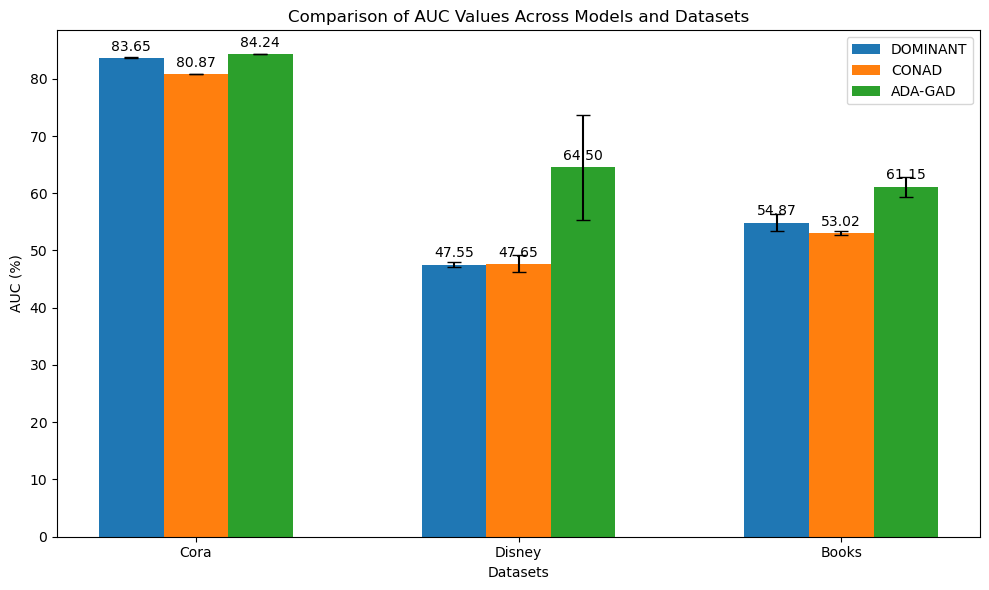

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# # 支持中文
# plt.rcParams['font.family'] = 'SimHei'  # 替换为你选择的字体
# plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 数据定义
Dominant = {
    "Cora": [0.836668922, 0.837413297, 0.835445215],
    'Disney': [0.481638418079096, 0.47175141242937846, 0.4731638418079096],
    'Books': [0.5671505652620761, 0.5318730729701953, 0.5471223021582734]
}

Conad = {
    "Cora": [0.8089, 0.8086, 0.8085],
    'Disney': [0.4633, 0.4972, 0.4689],
    'Books': [0.5325, 0.5256, 0.5326]
}

Adagad = {
    "Cora": [0.8424237297693565, 0.8424801218068009, 0.8423870749450179],
    'Disney': [0.612994350282486, 0.5522598870056497, 0.7697740112994351],
    'Books': [0.6355986639260021, 0.6047918807810895, 0.5942317574511818]
}

# 将 AUC 值转换为百分数形式
def convert_to_percentage(data):
    return {key: [value * 100 for value in values] for key, values in data.items()}

Dominant_pct = convert_to_percentage(Dominant)
Conad_pct = convert_to_percentage(Conad)
Adagad_pct = convert_to_percentage(Adagad)

# 数据集和模型名称
datasets = ["Cora", "Disney", "Books"]
models = ["Dominant", "Conad", "Adagad"]

# 计算每个数据集的平均值和标准差
mean_values = {
    "Dominant": [np.mean(Dominant_pct[ds]) for ds in datasets],
    "Conad": [np.mean(Conad_pct[ds]) for ds in datasets],
    "Adagad": [np.mean(Adagad_pct[ds]) for ds in datasets]
}

std_values = {
    "Dominant": [np.std(Dominant_pct[ds]) for ds in datasets],
    "Conad": [np.std(Conad_pct[ds]) for ds in datasets],
    "Adagad": [np.std(Adagad_pct[ds]) for ds in datasets]
}

# 绘制条形图
x = np.arange(len(datasets))  # x 轴位置
width = 0.2  # 条形宽度

fig, ax = plt.subplots(figsize=(10, 6))

# 绘制每个模型的条形图
bars1 = ax.bar(x - width, mean_values["Dominant"], width, yerr=std_values["Dominant"], label="DOMINANT", capsize=5)
bars2 = ax.bar(x, mean_values["Conad"], width, yerr=std_values["Conad"], label="CONAD", capsize=5)
bars3 = ax.bar(x + width, mean_values["Adagad"], width, yerr=std_values["Adagad"], label="ADA-GAD", capsize=5)

# 添加标签、标题和图例
ax.set_xlabel("Datasets")
ax.set_ylabel("AUC (%)")
ax.set_title("Comparison of AUC Values Across Models and Datasets")
# ax.set_title("不同模型和数据集的AUC（百分数）比较")
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

# 显示数值标签
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.savefig("auc_comparison.png", dpi=300, bbox_inches='tight')  # 保存为 PNG 文件
plt.show()

In [2]:
import pandas as pd

# 数据定义
Dominant = {
    "Cora": [0.836668922, 0.837413297, 0.835445215],
    'Disney': [0.481638418079096, 0.47175141242937846, 0.4731638418079096],
    'Books': [0.5671505652620761, 0.5318730729701953, 0.5471223021582734]
}

Conad = {
    "Cora": [0.8089, 0.8086, 0.8085],
    'Disney': [0.4633, 0.4972, 0.4689],
    'Books': [0.5325, 0.5256, 0.5326]
}

Adagad = {
    "Cora": [0.8424237297693565, 0.8424801218068009, 0.8423870749450179],
    'Disney': [0.612994350282486, 0.5522598870056497, 0.7697740112994351],
    'Books': [0.6355986639260021, 0.6047918807810895, 0.5942317574511818]
}

# 将 AUC 值转换为百分数形式并计算均值和标准差
def process_data(data):
    pct_data = {key: [value * 100 for value in values] for key, values in data.items()}
    mean_values = {key: np.mean(values) for key, values in pct_data.items()}
    std_values = {key: np.std(values) for key, values in pct_data.items()}
    return {key: f"{mean:.2f}±{std:.2f}" for key, mean, std in zip(pct_data.keys(), mean_values.values(), std_values.values())}

Dominant_processed = process_data(Dominant)
Conad_processed = process_data(Conad)
Adagad_processed = process_data(Adagad)

# 创建 DataFrame
df = pd.DataFrame({
    'Dataset': list(Dominant_processed.keys()),
    'Dominant': list(Dominant_processed.values()),
    'Conad': list(Conad_processed.values()),
    'Adagad': list(Adagad_processed.values())
})

# 设置 Dataset 列为索引
df.set_index('Dataset', inplace=True)

# 打印表格
print(df)

# 可选：将表格保存为 CSV 文件
df.to_csv("auc_table.csv")

           Dominant       Conad      Adagad
Dataset                                    
Cora     83.65±0.08  80.87±0.02  84.24±0.00
Disney   47.55±0.44  47.65±1.48  64.50±9.16
Books    54.87±1.44  53.02±0.33  61.15±1.75


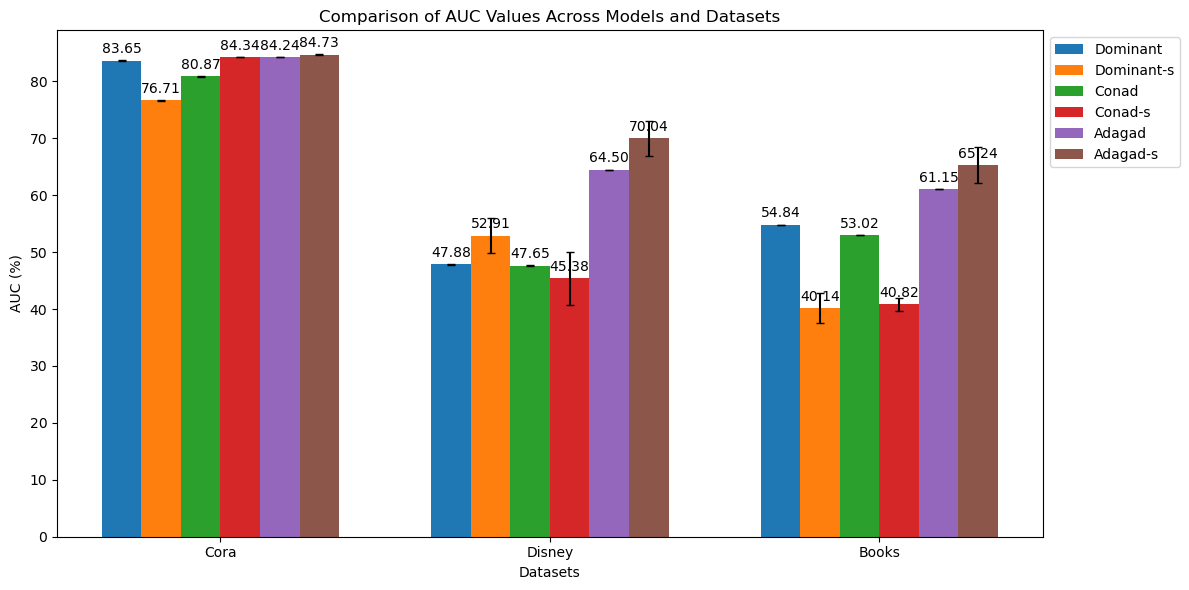

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 数据定义
data = {
    "Cora": {
        "Dominant": (83.65, 0.06), "Dominant-s": (76.71, 0.07),
        "Conad": (80.87, 0.01), "Conad-s": (84.34, 0.03),
        "Adagad": (84.24, 0.00), "Adagad-s": (84.73, 0.01)
    },
    "Disney": {
        "Dominant": (47.88, 0.05), "Dominant-s": (52.91, 3.04),
        "Conad": (47.65, 0.02), "Conad-s": (45.38, 4.64),
        "Adagad": (64.50, 0.01), "Adagad-s": (70.04, 3.08)
    },
    "Books": {
        "Dominant": (54.84, 0.01), "Dominant-s": (40.14, 2.66),
        "Conad": (53.02, 0.00), "Conad-s": (40.82, 1.18),
        "Adagad": (61.15, 0.01), "Adagad-s": (65.24, 3.17)
    }
}

# 数据集和模型名称
datasets = ["Cora", "Disney", "Books"]
models = ["Dominant", "Dominant-s", "Conad", "Conad-s", "Adagad", "Adagad-s"]

# 提取均值和标准差
mean_values = {ds: [data[ds][model][0] for model in models] for ds in datasets}
std_values = {ds: [data[ds][model][1] for model in models] for ds in datasets}

# 绘制条形图
x = np.arange(len(datasets))  # x 轴位置
width = 0.12  # 条形宽度
n_models = len(models)

fig, ax = plt.subplots(figsize=(12, 6))

# 绘制每个模型的条形图
for i, model in enumerate(models):
    means = [mean_values[ds][i] for ds in datasets]
    stds = [std_values[ds][i] for ds in datasets]
    bars = ax.bar(x + i * width, means, width, yerr=stds, label=model, capsize=3)

# 添加标签、标题和图例
ax.set_xlabel("Datasets")
ax.set_ylabel("AUC (%)")
ax.set_title("Comparison of AUC Values Across Models and Datasets")
ax.set_xticks(x + (n_models - 1) * width / 2)
ax.set_xticklabels(datasets)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# 显示数值标签
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# 遍历所有条形并添加标签
for i, model in enumerate(models):
    means = [mean_values[ds][i] for ds in datasets]
    for j, mean in enumerate(means):
        ax.annotate(f"{mean:.2f}",
                    xy=(x[j] + i * width, mean),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()

# 保存图表为图片文件
plt.savefig("auc_comparison_extended.png", dpi=300, bbox_inches='tight')  # 保存为 PNG 文件

# 显示图表
plt.show()

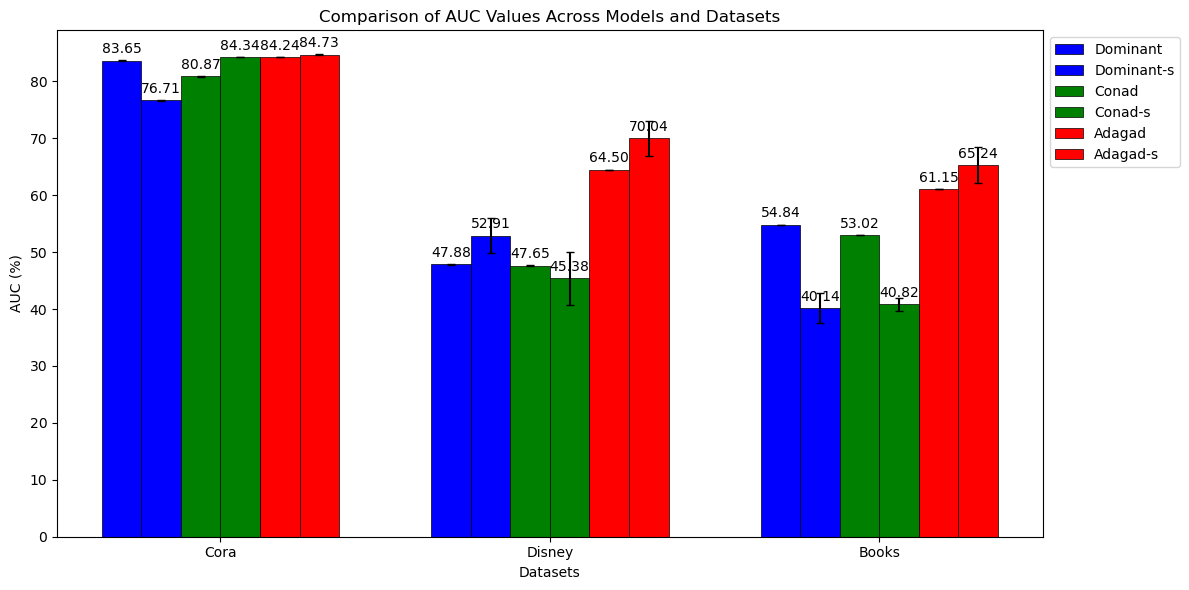

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 数据定义
data = {
    "Cora": {
        "Dominant": (83.65, 0.06), "Dominant-s": (76.71, 0.07),
        "Conad": (80.87, 0.01), "Conad-s": (84.34, 0.03),
        "Adagad": (84.24, 0.00), "Adagad-s": (84.73, 0.01)
    },
    "Disney": {
        "Dominant": (47.88, 0.05), "Dominant-s": (52.91, 3.04),
        "Conad": (47.65, 0.02), "Conad-s": (45.38, 4.64),
        "Adagad": (64.50, 0.01), "Adagad-s": (70.04, 3.08)
    },
    "Books": {
        "Dominant": (54.84, 0.01), "Dominant-s": (40.14, 2.66),
        "Conad": (53.02, 0.00), "Conad-s": (40.82, 1.18),
        "Adagad": (61.15, 0.01), "Adagad-s": (65.24, 3.17)
    }
}

# 数据集和模型名称
datasets = ["Cora", "Disney", "Books"]
models = ["Dominant", "Dominant-s", "Conad", "Conad-s", "Adagad", "Adagad-s"]

# 提取均值和标准差
mean_values = {ds: [data[ds][model][0] for model in models] for ds in datasets}
std_values = {ds: [data[ds][model][1] for model in models] for ds in datasets}

# 定义颜色映射
colors = {
    "Dominant": 'blue',
    "Conad": 'green',
    "Adagad": 'red'
}

# 绘制条形图
x = np.arange(len(datasets))  # x 轴位置
width = 0.12  # 条形宽度
n_models = len(models)

fig, ax = plt.subplots(figsize=(12, 6))

# 绘制每个模型的条形图
for i, model in enumerate(models):
    means = [mean_values[ds][i] for ds in datasets]
    stds = [std_values[ds][i] for ds in datasets]
    color = colors[model.split('-')[0]]  # 根据模型前缀选择颜色
    bars = ax.bar(x + i * width, means, width, yerr=stds, label=model, capsize=3,
                  color=color, edgecolor='black', linewidth=0.5)  # 添加黑色描边

# 添加标签、标题和图例
ax.set_xlabel("Datasets")
ax.set_ylabel("AUC (%)")
ax.set_title("Comparison of AUC Values Across Models and Datasets")
ax.set_xticks(x + (n_models - 1) * width / 2)
ax.set_xticklabels(datasets)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# 显示数值标签
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# 遍历所有条形并添加标签
for i, model in enumerate(models):
    means = [mean_values[ds][i] for ds in datasets]
    for j, mean in enumerate(means):
        ax.annotate(f"{mean:.2f}",
                    xy=(x[j] + i * width, mean),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()

# 保存图表为图片文件
plt.savefig("auc_comparison_extended_with_outline.png", dpi=300, bbox_inches='tight')  # 保存为 PNG 文件

# 显示图表
plt.show()